# Previously on the IBM Quantum Challenge
*Ryoko has been stuck in the quantum realm. Please DM Ryoko and ask her about the **quantum realm** and you will find out more.  <br/>
She is in a square room with excited qubits blocking her passage. <br/>
How can you help Dr. Ryoko get out of the room?<br/>
You can do this by learning how to solve a famous classic puzzle called "lights out." Good luck!*

[<< Click here to communicate with Dr. Ryoko through the web cam >>](https://youtu.be/kLizHnvTguE)

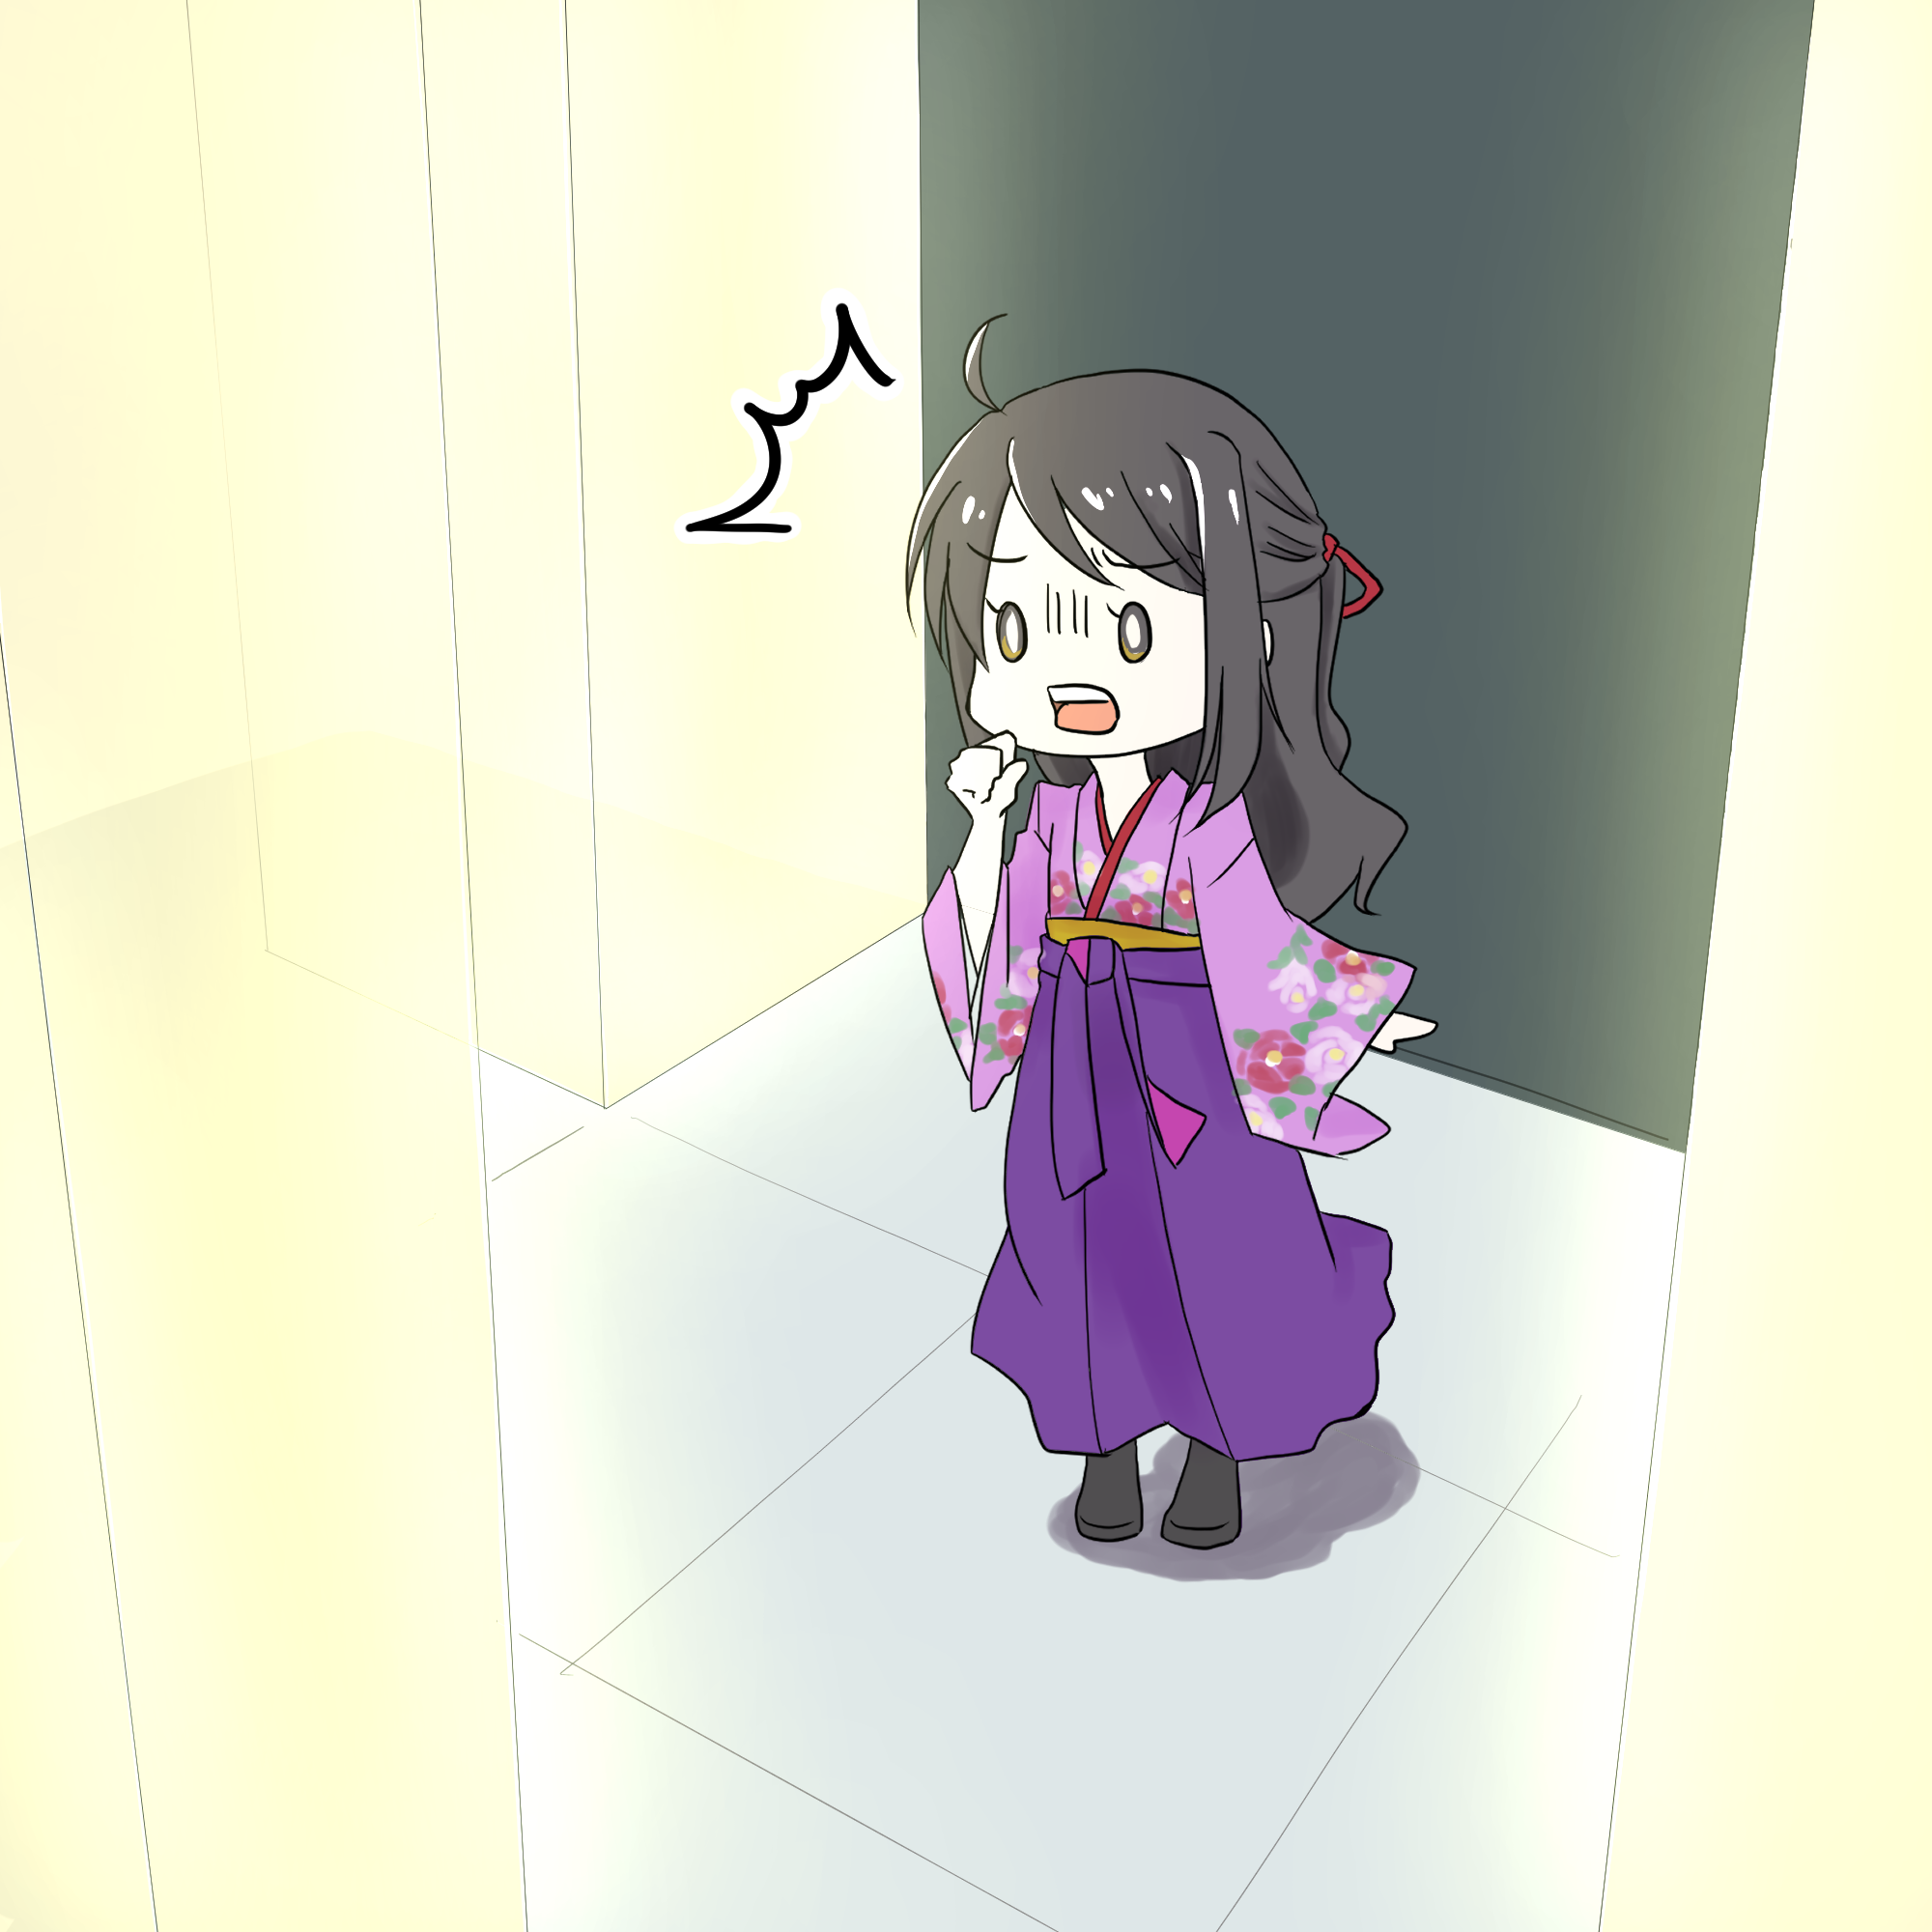

In [1]:
from IPython.display import Image, display
Image('ryoko_pillars.png')

# Week2-A: Lights Out Puzzle

**Lights out** is a famous puzzle game. The player is given a rectangular grid of lights which can be switched on and off. When you flip a switch inside one of those squares, it will toggle the on/off state of this and adjacent squares (up, down, left and right). Your goal is to turn all the lights off from a random starting light pattern.

## Example Puzzle

An example of the puzzle with 3 x 3 grid is shown in the figure below. The light squares are labelled from 0 to 8. We can represent the starting pattern using a list of numbers, where `1` represents lights switched on and `0` represnts ligths switched off. The list `lights` below represents the starting pattern in this example (squares 3, 5, 6, 7 are on and the rest are off):

```python
lights = [0, 0, 0, 1, 0, 1, 1, 1, 0]
```

The example puzzle can be solved by flipping the switches in square 0, 3 and 4 as illustrated step by step in the figure. If you play with it a little bit, you will soon notice **two important properties of this puzzle game**:

1. You don't need to flip a switch more than once.
2. The order of flipping doesn't matter.

Therefore, we can represent the puzzle solution as a list of numbers similar to the starting pattern. However, the meaning of `0` and `1` are different here:  `1` represents flipping a switch and `0` represents *not* flipping a switch. 

```python
solution = [1, 0, 0, 1, 1, 0, 0, 0, 0]
```

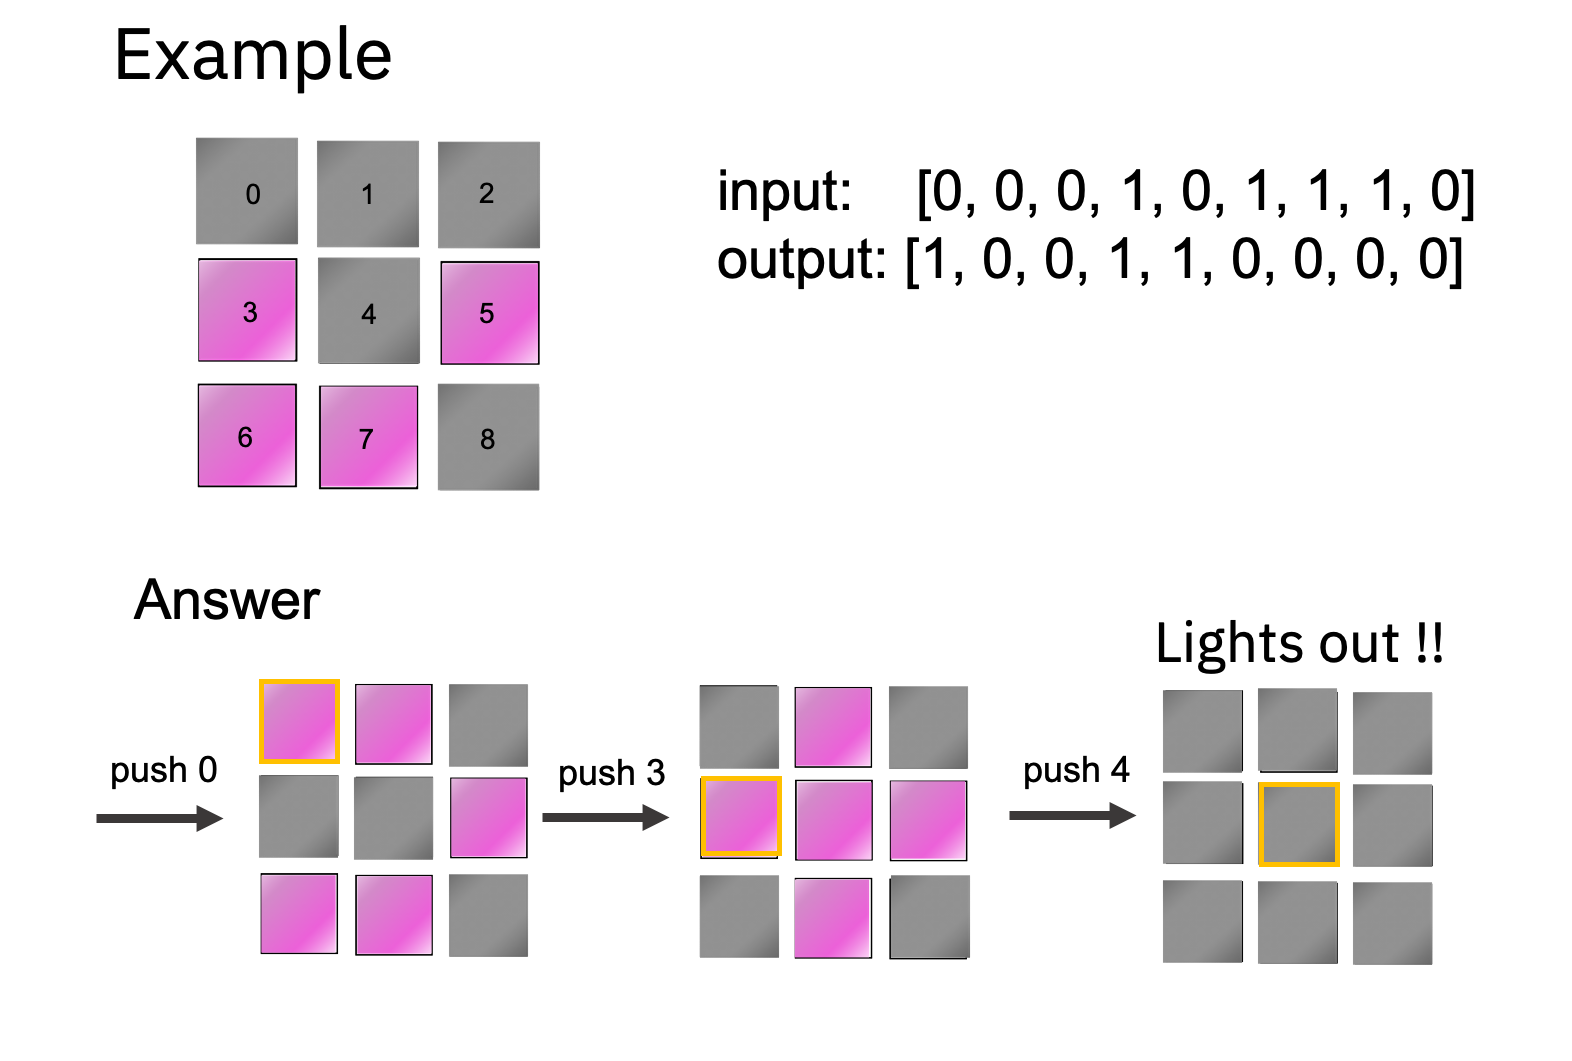

In [2]:
Image('lights_out_rule.png')

# Learning Exercise II-A

Let's try to solve a "Lights Out" puzzle using **Grover's algorithm**! The information you learned last week will be helpful in solving this puzzle.

Answer by creating a quantum circuit to solve the puzzle shown in the figure below. In the quantum circuit to be submitted, measure **only the `solution` (9bit)** that solves the puzzle. 
To submit your solution, create a function which takes `lights` as an input and then returns a  `QuantumCircuit`.  You can name the function as you like. Make sure it works even with another dataset of "lights". We will validate your circuit with different inputs.

**In addition, please implement the quantum circuit within 28 qubits.**

There are several ways to solve it without using Grover's algorithm, but we ask you to **use Grover's algorithm** for this exercise. It should help you in solving other challenges.

Please note that you can get the answer with the same endian as the one used in the description. You can also use the following function.
```python
qc = qc.reverse_bits()
```

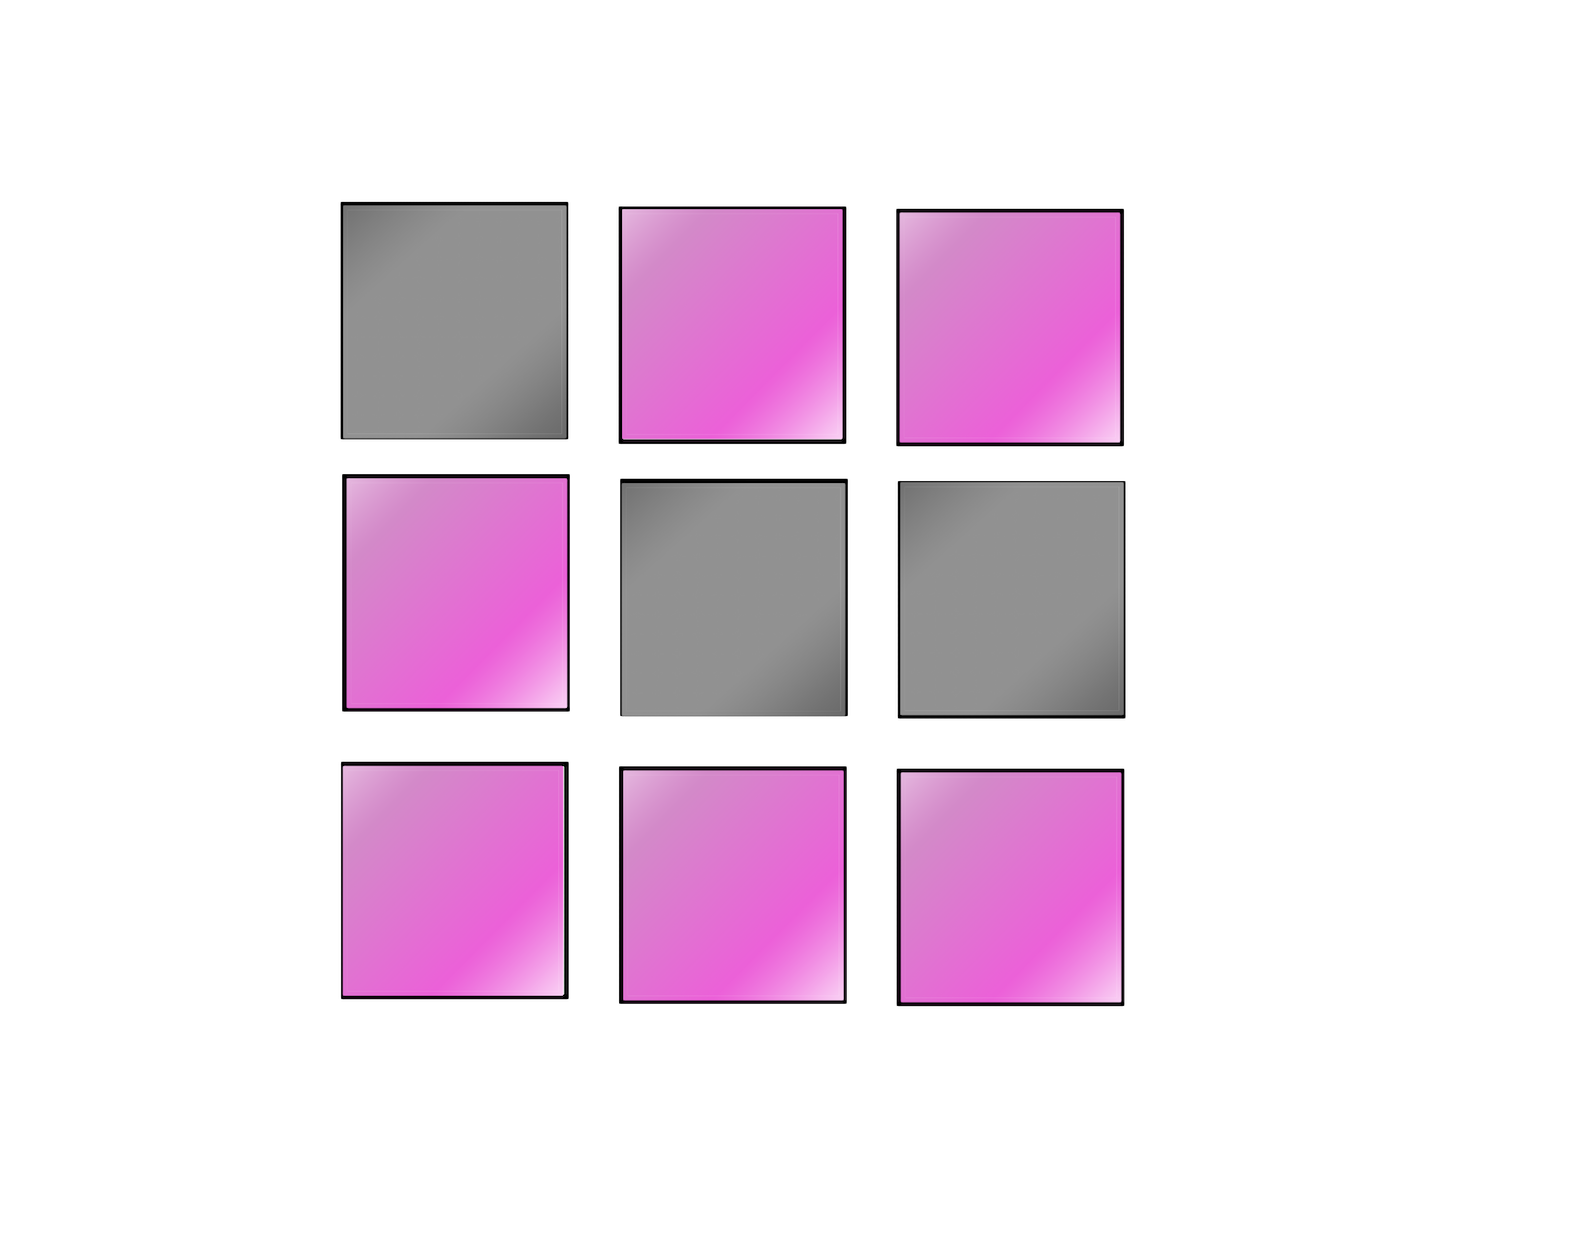

In [3]:
Image('lights_out_prob.png')

## Hint
You’ll need a more complex oracle than the “Week1-B oracle” to solve this problem. The added auxiliary qubits will help you design the oracle part, but they need to be handled with care.  At the end of the oracle part, all auxiliary qubits must be returned to their initial state (this operation is sometimes called Uncomputation). [Week 3 of last year’s IBM Quantum Challenge](https://github.com/quantum-challenge/2019/blob/master/problems/week3/week3_en.ipynb) will support your understanding of this concept. 

If you are not sure about the optimal number of iterations for Grover's algorithm, solve [this quiz](https://github.com/qiskit-community/IBMQuantumChallenge2020/tree/main/quizzes/quiz_1) and talk to Dr. Ryoko(@ryoko) in the [Qiskit slack](qiskit.slack.com) via direct message. You can get important formulas of the theoretical aspects of week 1-B.

In [1]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

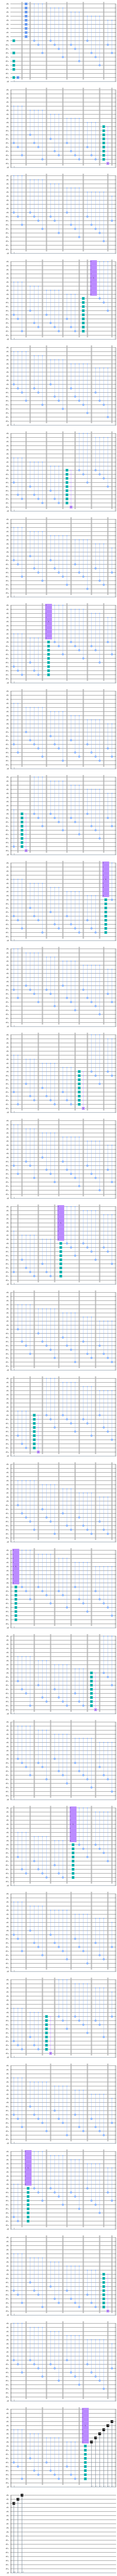

In [2]:
# The starting pattern is represented by this list of numbers.
# Please use it as an input for your solution.
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute
from qiskit.visualization import plot_bloch_multivector
#lights = [0, 1, 1, 1, 0, 0, 1, 1, 1]
lights = [1, 0, 0, 1, 0, 1, 1, 1, 0]

q_dict = {'0' : [9,10,12],
          '1' : [9,10,11,13],
          '2' : [10,11,14],
          '3' : [9,12,13,15],
          '4' : [10,12,13,14,16],
          '5' : [11,13,14,17],
          '6' : [12,15,16],
          '7' : [13,15,16,17],
          '8' : [14,16,17]}

q_dict_inv = {'8' : [17,16,14],
              '7' : [17,16,15,13],
              '6' : [16,15,12],
              '5' : [17,14,13,11],
              '4' : [16,14,13,12,10],
              '3' : [15,13,12,9],
              '2' : [14,11,10],
              '1' : [13,11,10,9],
              '0' : [12,10,9]}



def light_oracle(qc,q):
    for cell in q_dict:   
        # Here, the controled gates for each dell are placed.
        for near_cell in q_dict[cell]:
            qc.cx(q[int(cell)], q[near_cell])
        qc.barrier()
    # Here I have reversed all the wubits, because we want de state|0..0>
    # and if I want to use the multicontroled gate I need that all to be |1...1>
    for cell in q_dict:
        qc.x(q[int(cell)+9])
    # Here I apply the multicontrolled gate 
    qc.mct(q[9:18], q[18])
    
    qc.barrier()
    #Finally I make the uncomputing (repeat the first part)
    for cell in q_dict:
        for near_cell in q_dict[cell]:
            qc.cx(q[int(cell)], q[near_cell])
        qc.barrier()
    for cell in q_dict:
        qc.x(q[int(cell)+9])
    # Thus I finish the oracle
    

def week2a_ans_func(lights):
    ##### build your quantum circuit here
    q = QuantumRegister(19)
    c = ClassicalRegister(9)
    qc = QuantumCircuit(q, c)
    for i in range(9):
        if lights[i] == 1:
            qc.x(q[i+9])
    qc.x(q[18])
    qc.h(q[18])
    qc.barrier()
        

    for i in range(9):
        qc.h(q[i])
    qc.barrier()
    light_oracle(qc,q)
    
    qc.barrier()
    qc.append(diffuser(9), [0,1,2,3,4,5,6,7,8])
    light_oracle(qc,q)
    qc.append(diffuser(9), [0,1,2,3,4,5,6,7,8])
    light_oracle(qc,q)
    qc.append(diffuser(9), [0,1,2,3,4,5,6,7,8])
    light_oracle(qc,q)
    qc.append(diffuser(9), [0,1,2,3,4,5,6,7,8])
    light_oracle(qc,q)
    qc.append(diffuser(9), [0,1,2,3,4,5,6,7,8])
    light_oracle(qc,q)
    qc.append(diffuser(9), [0,1,2,3,4,5,6,7,8])
    light_oracle(qc,q)
    qc.append(diffuser(9), [0,1,2,3,4,5,6,7,8])
    light_oracle(qc,q)
    qc.append(diffuser(9), [0,1,2,3,4,5,6,7,8])
    qc.measure(q[[8,7,6,5,4,3,2,1,0]],c)

    
    #####  In addition, please make it a function that can solve the problem even with different inputs (lights). We do validation with different inputs.

    return qc

qc = week2a_ans_func(lights)
qc.draw(output='mpl')


In [ ]:
# Submission code
from qc_grader import prepare_ex2a, grade_ex2a, submit_ex2a
from qiskit.visualization import plot_histogram
# Execute your circuit with following prepare_ex2a() function.
# The prepare_ex2a () function works like the execute() function with only QuantumCircuit as an argument.
job = prepare_ex2a(week2a_ans_func)

result = job.result()
count = result.get_counts()
plot_histogram(result.get_counts())
original_problem_set_counts = count[0]


original_problem_set_counts

# The bit string with the highest number of observations is treated as the solution.

In [ ]:
cont = 0

for item in original_problem_set_counts:
    if original_problem_set_counts[item] > cont:
        cont = original_problem_set_counts[item]
        test = str(item)
print(test, cont)

In [ ]:
# Check your answer by executing following code.
# The quantum cost of the QuantumCircuit is obtained as the score. The quantum cost is related to rank only in the third week.
grade_ex2a(job)

In [ ]:
# Submit your results by executing following code. You can submit as many times as you like during the period. 
submit_ex2a(job)